# Waste Classification (Organic vs Recyclable) using CNN (TensorFlow / Keras)

This notebook trains a CNN to classify images as **Organic** (O) or **Recyclable** (R).

Project structure expected:
sustainability_cnn/
├── data/
│ ├── train/
│ │ ├── O/
│ │ └── R/
│ └── test/
│ ├── O/
│ └── R/
├── src/
├── models/
└── notebooks/

In [1]:
# Imports and GPU detection
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# ensure project root is on path so `import src.*` works
sys.path.append(os.path.abspath(".."))  # notebook located in notebooks/

print("Python:", sys.executable)
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:" if gpus else "No GPU detected — training will use CPU.", gpus)


Python: m:\Sustainability_CNN\.venv\Scripts\python.exe
TensorFlow version: 2.20.0
No GPU detected — training will use CPU. []


In [2]:
# Ensure python can import our src module (adjust path if notebook is in notebooks/)
import sys
sys.path.append(os.path.abspath(os.path.join('..')))  # if notebook is in notebooks/
from src.data_loader import create_generators
from src.model_builder import build_cnn
from src.train import train


In [3]:
# Hyperparameters and paths (updated to match improved src defaults)
DATA_DIR = "../data"         # relative to notebooks/
MODEL_PATH = "../models/waste_classifier.h5"
TARGET_SIZE = (128, 128)     # updated default
BATCH_SIZE = 32              # updated default
EPOCHS = 12
USE_TRANSFER = True         # set True to use MobileNetV2 transfer learning
WORKERS = 4


In [4]:
# Create generators using updated create_generators()
from src.data_loader import create_generators
train_gen, val_gen, test_gen, class_indices = create_generators(
    DATA_DIR, target_size=TARGET_SIZE, batch_size=BATCH_SIZE
)
print("Class indices:", class_indices)


Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


INFO:src.data_loader:Class indices: {'O': 0, 'R': 1}


Class indices: {'O': 0, 'R': 1}


In [5]:
# Build model (choose transfer or from-scratch)
from src.model_builder import build_cnn, build_transfer

if USE_TRANSFER:
    model = build_transfer(input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3), dropout_rate=0.5)
    optimizer = tf.keras.optimizers.Adam(1e-4)
else:
    model = build_cnn(input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3), dropout_rate=0.5)
    optimizer = tf.keras.optimizers.Adam(1e-3)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau  #type: ignore
import os
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

# Training (quick fix: remove workers/use_multiprocessing)
checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)
early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint, early, reduce_lr]
)


Epoch 1/12
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.7900 - loss: 0.4986
Epoch 1: val_accuracy improved from None to 0.92819, saving model to ../models/waste_classifier.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 580s 1s/step - accuracy: 0.8459 - loss: 0.3997 - val_accuracy: 0.9282 - val_loss: 0.2399 - learning_rate: 1.0000e-04
Epoch 2/12
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8972 - loss: 0.3042
Epoch 2: val_accuracy improved from 0.92819 to 0.92930, saving model to ../models/waste_classifier.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 258s 457ms/step - accuracy: 0.8967 - loss: 0.3018 - val_accuracy: 0.9293 - val_loss: 0.2334 - learning_rate: 1.0000e-04
Epoch 3/12
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9047 - loss: 0.2809
Epoch 3: val_accuracy did not improve from 0.92930
565/565 ━━━━━━━━━━━━━━━━━━━━ 261s 462ms/step - accuracy: 0.9064 - loss: 0.2769 - val_accuracy: 0.9251 - val_loss: 0.2405 - learning_rate: 1.0000e-04
Epoch 4/12
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9106 - loss: 0.2641
Epoch 4: val_accuracy did not improve from 0.92930
565/565 ━━━━━━━━━━━━━━━━━━━━ 252s 445ms/step - accuracy: 0.9121 - loss: 0.2597 - val_accuracy: 0.9262 - val_loss: 0.2309 - learning_rate: 1.0000e-04
Epoch 5/12
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9120 - loss: 0.2552
Epoch 5: val_accuracy improved from 0.92930 to 0.93307, saving model to ../models/waste_classifier.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 289s 512ms/step - accuracy: 0.9140 - loss: 0.2527 - val_accuracy: 0.9331 - val_loss: 0.2243 - learning_rate: 1.0000e-04
Epoch 6/12
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9250 - loss: 0.2396
Epoch 6: val_accuracy did not improve from 0.93307
565/565 ━━━━━━━━━━━━━━━━━━━━ 271s 480ms/step - accuracy: 0.9216 - loss: 0.2420 - val_accuracy: 0.9304 - val_loss: 0.2212 - learning_rate: 1.0000e-04
Epoch 7/12
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9229 - loss: 0.2334
Epoch 7: val_accuracy did not improve from 0.93307
565/565 ━━━━━━━━━━━━━━━━━━━━ 269s 476ms/step - accuracy: 0.9239 - loss: 0.2347 - val_accuracy: 0.9262 - val_loss: 0.2330 - learning_rate: 1.0000e-04
Epoch 8/12
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9270 - loss: 0.2259
Epoch 8: val_accuracy did not improve from 0.93307
565/565 ━━━━━━━━━━━━━━━━━━━━ 259s 458ms/step - accuracy: 0.9252 - loss: 0.2318 - val_accuracy: 0.9300 - val_loss: 0.2201 - learning_rate

In [ ]:
# #diagnostic1
# from tensorflow.keras.models import load_model # type: ignore
# import os

# best_model_path = "../models/waste_classifier.h5"  # checkpoint saved by ModelCheckpoint
# model = load_model(best_model_path)

# # evaluate on test generator (assuming you still have test_gen from create_generators)
# test_loss, test_acc = model.evaluate(test_gen, verbose=1)
# print("Best checkpoint test acc:", test_acc, "loss:", test_loss)


2513/2513 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.8583 - loss: 0.3383
Best checkpoint test acc: 0.8583366274833679 loss: 0.33833959698677063


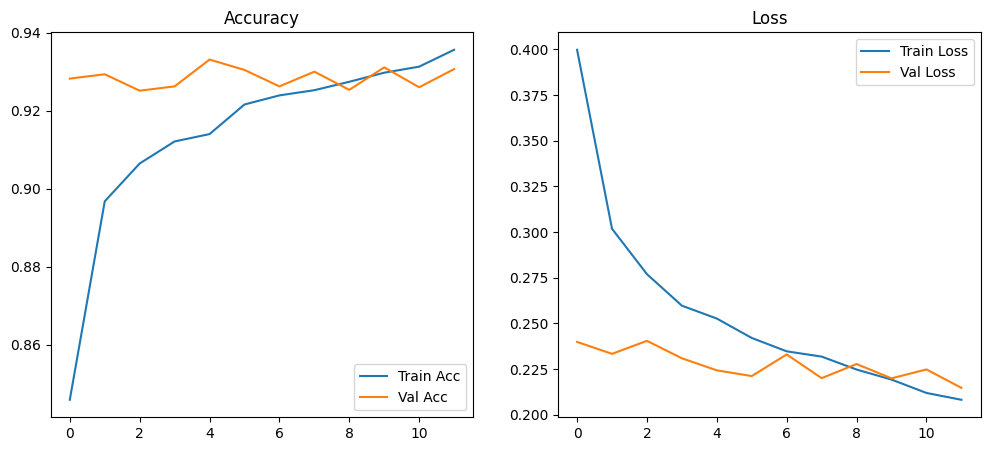

In [8]:
# Plot training accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [9]:
# test_loss, test_acc = model.evaluate(test_gen, verbose=1)
# print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

from tensorflow.keras.models import load_model #type: ignore
best_model = load_model(MODEL_PATH)
test_loss, test_acc = best_model.evaluate(test_gen, verbose=1)
print(f"Best model test accuracy: {test_acc:.4f}, loss: {test_loss:.4f}")


2513/2513 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - accuracy: 0.8945 - loss: 0.2989
Best model test accuracy: 0.8945, loss: 0.2989


In [ ]:
# from tensorflow.keras.models import load_model   # type: ignore
# from PIL import Image
# import numpy as np
# import ipywidgets as widgets
# from IPython.display import display

# best_model = load_model(MODEL_PATH)
# print("Model loaded from:", MODEL_PATH)

# # Helper
# def preprocess(path):
#     img = Image.open(path).convert('RGB').resize(TARGET_SIZE)
#     arr = np.array(img)/255.0
#     return np.expand_dims(arr,0)

# def predict_file(path):
#     x = preprocess(path)
#     score = best_model.predict(x)[0][0]
#     label = "Recyclable" if score>=0.5 else "Organic"
#     return score, label

# # Simple file upload widget for interactive test
# uploader = widgets.FileUpload(accept='image/*', multiple=False)
# out = widgets.Output()

# def on_upload_change(change):
#     out.clear_output()
#     for name, file_info in uploader.value.items():
#         with open("../tmp_uploaded.jpg","wb") as f:
#             f.write(file_info['content'])
#         score, label = predict_file("../tmp_uploaded.jpg")
#         with out:
#             print(f"File: {name}")
#             print(f"Raw score (sigmoid): {score:.4f}")
#             print(f"Predicted: {label}")
#             display(Image.open("../tmp_uploaded.jpg").resize((200,200)))

# uploader.observe(on_upload_change, names='value')
# display(uploader, out)


Model loaded from: ../models/waste_classifier.h5


FileUpload(value=(), accept='image/*', description='Upload')

Output()

AttributeError: 'tuple' object has no attribute 'items'

In [11]:
# Fine-tuning setup cell
import os
import tensorflow as tf
from tensorflow.keras import mixed_precision   #type: ignore
from tensorflow.keras.optimizers import Adam  #type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau  #type: ignore
from tensorflow.keras.models import load_model   #type: ignore
import numpy as np
import matplotlib.pyplot as plt

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

# Ensure train_gen/val_gen/test_gen exist
try:
    train_gen, val_gen, test_gen  # noqa: F821
    print("train_gen, val_gen, test_gen present in session.")
except NameError:
    from src.data_loader import create_generators  # type: ignore
    # adjust DATA_DIR, TARGET_SIZE, BATCH_SIZE if needed
    DATA_DIR = "../data" if os.path.exists("../data") else "data"
    TARGET_SIZE = (128,128)
    BATCH_SIZE = 64
    train_gen, val_gen, test_gen, _ = create_generators(DATA_DIR, target_size=TARGET_SIZE, batch_size=BATCH_SIZE)
    print("Generators recreated.")


TF version: 2.20.0
GPUs: []
train_gen, val_gen, test_gen present in session.


In [ ]:
# Build transfer model (MobileNetV2) and train only the top head first
from tensorflow.keras.applications import MobileNetV2   #type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout  #type: ignore
from tensorflow.keras.models import Model  #type: ignore

# hyperparams (tweakable)
head_epochs = 4        # train only head
finetune_epochs = 6    # epochs for fine-tuning stage
unfreeze_layers = 50   # number of layers from the end of the base to unfreeze
initial_lr = 1e-4      # LR for head training
finetune_lr = 1e-5     # LR for fine-tuning

# Build base
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
base.trainable = False   # freeze base for head training

# Add top head
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid', dtype='float32')(x)
model_tl = Model(inputs=base.input, outputs=out)

model_tl.compile(optimizer=Adam(learning_rate=initial_lr), loss='binary_crossentropy', metrics=['accuracy'])
model_tl.summary()

# Callbacks
ft_model_path = "../models/waste_classifier_finetuned.h5"
os.makedirs(os.path.dirname(ft_model_path), exist_ok=True)
checkpoint_head = ModelCheckpoint(ft_model_path, monitor='val_accuracy', save_best_only=True, verbose=1)
early_head = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_head = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train head
history_head = model_tl.fit(
    train_gen,
    validation_data=val_gen,
    epochs=head_epochs,
    callbacks=[checkpoint_head, early_head, reduce_head]
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/4
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.7988 - loss: 0.4333
Epoch 1: val_accuracy improved from None to 0.92088, saving model to ../models/waste_classifier_finetuned.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 464s 809ms/step - accuracy: 0.8502 - loss: 0.3495 - val_accuracy: 0.9209 - val_loss: 0.2100 - learning_rate: 1.0000e-04
Epoch 2/4
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8912 - loss: 0.2644
Epoch 2: val_accuracy improved from 0.92088 to 0.92598, saving model to ../models/waste_classifier_finetuned.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 251s 444ms/step - accuracy: 0.8950 - loss: 0.2596 - val_accuracy: 0.9260 - val_loss: 0.1970 - learning_rate: 1.0000e-04
Epoch 3/4
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9062 - loss: 0.2441
Epoch 3: val_accuracy improved from 0.92598 to 0.92664, saving model to ../models/waste_classifier_finetuned.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 270s 478ms/step - accuracy: 0.9084 - loss: 0.2365 - val_accuracy: 0.9266 - val_loss: 0.1870 - learning_rate: 1.0000e-04
Epoch 4/4
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.9100 - loss: 0.2211
Epoch 4: val_accuracy improved from 0.92664 to 0.93019, saving model to ../models/waste_classifier_finetuned.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 537s 950ms/step - accuracy: 0.9103 - loss: 0.2223 - val_accuracy: 0.9302 - val_loss: 0.1871 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 3.


In [13]:
# Fine-tune: unfreeze last `unfreeze_layers` layers of the base and train at low LR
# Re-load the best head weights saved above (optional) to ensure we start from best head
if os.path.exists(ft_model_path):
    print("Loading best head weights from:", ft_model_path)
    model_tl = load_model(ft_model_path)  # reload to get best head
    # base may be inside the loaded model; find it
    base = None
    for layer in model_tl.layers:
        if isinstance(layer, tf.keras.Model) and layer.name.startswith('mobilenetv2'):
            base = layer
            break
    # If base not found by above (rare), re-create base and attach weights; but typically loaded model has base inside.
else:
    print("Warning: head checkpoint not found; continuing with in-memory model.")

# Make base trainable for last N layers
# If the base is the MobileNetV2 model object we built earlier, set trainable appropriately
base = None
for layer in model_tl.layers:
    if 'mobilenetv2' in layer.name or 'Conv' in layer.name:
        # try to detect base model; safer approach below reassigns base to first layer group with trainable weights
        pass

# Simpler: get the MobileNetV2 instance as model_tl.layers[0] or by name
# We'll find the first layer with name 'mobilenetv2_1.00_128' or 'Conv1' etc.
# Instead, we'll iterate through model_tl.layers and set trainable flags
total_layers = len(model_tl.layers)
print("Total layers in model:", total_layers)

# Unfreeze from the end - set trainable True for last `unfreeze_layers` layers
for layer in model_tl.layers[:-unfreeze_layers]:
    layer.trainable = False
for layer in model_tl.layers[-unfreeze_layers:]:
    layer.trainable = True

# Recompile with a low learning rate
model_tl.compile(optimizer=Adam(learning_rate=finetune_lr), loss='binary_crossentropy', metrics=['accuracy'])
model_tl.summary()

# Callbacks for fine-tune
checkpoint_ft = ModelCheckpoint(ft_model_path, monitor='val_accuracy', save_best_only=True, verbose=1)
early_ft = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_ft = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Fine-tune
history_ft = model_tl.fit(
    train_gen,
    validation_data=val_gen,
    epochs=finetune_epochs,
    callbacks=[checkpoint_ft, early_ft, reduce_ft]
)


Loading best head weights from: ../models/waste_classifier_finetuned.h5


Total layers in model: 158


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 2,072,513 (7.91 MB)

 Non-trainable params: 513,664 (1.96 MB)

Epoch 1/6
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8806 - loss: 0.2925
Epoch 1: val_accuracy improved from None to 0.92930, saving model to ../models/waste_classifier_finetuned.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 328s 549ms/step - accuracy: 0.8926 - loss: 0.2680 - val_accuracy: 0.9293 - val_loss: 0.1940 - learning_rate: 1.0000e-05
Epoch 2/6
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9060 - loss: 0.2351
Epoch 2: val_accuracy improved from 0.92930 to 0.92996, saving model to ../models/waste_classifier_finetuned.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 324s 574ms/step - accuracy: 0.9069 - loss: 0.2331 - val_accuracy: 0.9300 - val_loss: 0.1829 - learning_rate: 1.0000e-05
Epoch 3/6
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.9175 - loss: 0.2147
Epoch 3: val_accuracy did not improve from 0.92996
565/565 ━━━━━━━━━━━━━━━━━━━━ 355s 628ms/step - accuracy: 0.9150 - loss: 0.2158 - val_accuracy: 0.9293 - val_loss: 0.1797 - learning_rate: 1.0000e-05
Epoch 4/6
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9160 - loss: 0.2110
Epoch 4: val_accuracy did not improve from 0.92996
565/565 ━━━━━━━━━━━━━━━━━━━━ 334s 590ms/step - accuracy: 0.9197 - loss: 0.2040 - val_accuracy: 0.9262 - val_loss: 0.1855 - learning_rate: 1.0000e-05
Epoch 5/6
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9245 - loss: 0.1927
Epoch 5: val_accuracy improved from 0.92996 to 0.93129, saving model to ../models/waste_classifier_finetuned.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
565/565 ━━━━━━━━━━━━━━━━━━━━ 335s 593ms/step - accuracy: 0.9250 - loss: 0.1922 - val_accuracy: 0.9313 - val_loss: 0.1839 - learning_rate: 1.0000e-05
Epoch 6/6
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9291 - loss: 0.1829
Epoch 6: val_accuracy improved from 0.93129 to 0.93794, saving model to ../models/waste_classifier_finetuned.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 327s 578ms/step - accuracy: 0.9287 - loss: 0.1827 - val_accuracy: 0.9379 - val_loss: 0.1711 - learning_rate: 5.0000e-06
Restoring model weights from the end of the best epoch: 6.


Loaded fine-tuned model from: ../models/waste_classifier_finetuned.h5
2513/2513 ━━━━━━━━━━━━━━━━━━━━ 64s 23ms/step - accuracy: 0.9184 - loss: 0.2141
Fine-tuned model test accuracy: 0.9184, loss: 0.2141
2513/2513 ━━━━━━━━━━━━━━━━━━━━ 60s 23ms/step

Classification report:
              precision    recall  f1-score   support

           O       0.90      0.96      0.93      1401
           R       0.94      0.87      0.90      1112

    accuracy                           0.92      2513
   macro avg       0.92      0.91      0.92      2513
weighted avg       0.92      0.92      0.92      2513



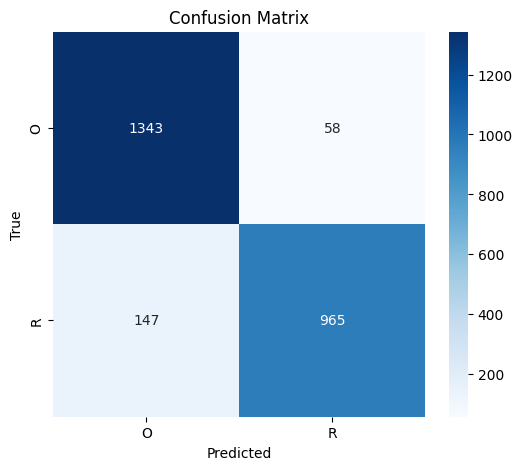

In [14]:
# Evaluate and confusion matrix for the fine-tuned best model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load best saved fine-tuned model
if os.path.exists(ft_model_path):
    model = load_model(ft_model_path)
    print("Loaded fine-tuned model from:", ft_model_path)
else:
    model = model_tl
    print("Using in-memory model object (no saved fine-tuned checkpoint found).")

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Fine-tuned model test accuracy: {test_acc:.4f}, loss: {test_loss:.4f}")

# Predictions & confusion matrix
test_gen.reset()
preds = model.predict(test_gen, verbose=1)
y_pred = (preds.ravel() >= 0.5).astype(int)
y_true = test_gen.classes
labels = [k for k, v in sorted(test_gen.class_indices.items(), key=lambda x: x[1])]

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()
